Plot results from gag 3D diffusion analysis runs, for cholesterol-derived lipid 3D tracking, at gag accumulation sites. Compare results in violin plots.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd
import os
from scipy.ndimage import uniform_filter1d

import sys
sys.path.append("..")
from DiffusionAnalysis3D import DiffusionAnalysis3D

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'arial'

def f_msd(dt, D, sigma):
    dim = 2  # dimensions
    Rblur = 1/6.2  # blurring factor
    dtmean = 350e-6  # smallest (and median) dt between localizations
    return 2*dim*D*dt + 2*dim*sigma**2 - 4*dim*Rblur*D*dtmean

# filter parameters
n_tracks_lim_incl = 20
n_tracks_lim_dapp = 5
fit_len_thresh = 15
n_tracks_lim_dtranscirc = 20
n_locs_dtrans = 50

parentdir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [2]:
# ALL - LOAD DATA AND READ DTRANS AND DAPP ANALYSIS RESULTS
dapps_all = []
dser_combos = []     
dtrans_all = []
dtrans_rats_all = []
dser_combos = []

folders = [os.path.join(parentdir, 'exampledata\\gag\\241114'),
              os.path.join(parentdir, 'exampledata\\gag\\250117')]

for folder in folders:
    print(folder)
    analysis = DiffusionAnalysis3D('analysis')
    analysis.load_pickleddata(folder)
    analysis.roi_data['date'] = pd.DataFrame([folder.split('\\')[-1] for i in range(len(analysis.roi_data))])
    analysis.track_data['date'] = pd.DataFrame([folder.split('\\')[-1] for i in range(len(analysis.track_data))])
    dates = analysis.track_data['date'].unique()
    for date in dates:
        data_d = analysis.track_data[analysis.track_data['date']==date].copy()
        samples = data_d['sample'].unique()
        for sample in samples:
            data_ds = data_d[data_d['sample']==sample].copy()
            events = data_ds['event'].unique()
            for event in events:
                data_dse = data_ds[data_ds['event']==event].copy()
                roinames = data_dse['roiname'].unique()
                for roiname in roinames:
                    data_dser = data_dse[data_dse['roiname']==roiname].copy()
                    cycles = data_dser['cycle'].unique()
                    dser_combos.append([date, sample, event, roiname])
                    for cycle in cycles:
                        data_dserc = data_dser[data_dser['cycle']==cycle].copy()
                        cycletime = data_dserc.iloc[0]['cycle_t_start_s']
                        dapps_ins = []
                        dapps_outs = []
                        for _, row in data_dserc.iterrows():
                            if ~np.isnan(row['dapp_in']):
                                dapps_ins.append(row['dapp_in'])
                            if ~np.isnan(row['dapp_out']):
                                dapps_outs.append(row['dapp_out'])
                        if len(dapps_ins) > 3 and len(dapps_outs) > 3:
                            dapps_all.append([[date, sample, event, roiname, cycle, cycletime], np.mean(dapps_ins), np.mean(dapps_outs), np.mean(dapps_ins)/np.mean(dapps_outs), np.std(dapps_ins)/np.sqrt(len(dapps_ins)), np.std(dapps_outs)/np.sqrt(len(dapps_outs)), np.sqrt(((np.std(dapps_ins)/np.sqrt(len(dapps_ins))/np.mean(dapps_ins))**2)+((np.std(dapps_outs)/np.sqrt(len(dapps_outs))/np.mean(dapps_outs))**2))])
                        else:
                            dapps_all.append([[date, sample, event, roiname, cycle, cycletime], np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
                       
    dates = analysis.roi_data['date'].unique()
    for date in dates:
        data_d = analysis.roi_data[analysis.roi_data['date']==date].copy()
        samples = data_d['sample'].unique()
        for sample in samples:
            data_ds = data_d[data_d['sample']==sample].copy()
            events = data_ds['event'].unique()
            for event in events:
                data_dse = data_ds[data_ds['event']==event].copy()
                roinames = data_dse['roiname'].unique()
                for roiname in roinames:
                    data_dser = data_dse[data_dse['roiname']==roiname].copy()
                    cycles = data_dser['cycle'].unique()
                    for cycle in cycles:
                        data_dserc = data_dser[data_dser['cycle']==cycle].copy()
                        cycletime = data_dserc.iloc[0]['cycle_t_start_s']
                        dtrans_inner = data_dserc.iloc[0]['dtrans_site_inner']
                        dtrans_peri = data_dserc.iloc[0]['dtrans_site_peri']
                        dtrans_outer = data_dserc.iloc[0]['dtrans_site_outside']
                        if np.count_nonzero(~np.isnan(dtrans_inner)) > 20 and np.count_nonzero(~np.isnan(dtrans_outer)) > 20:
                            try:
                                dtrans_all.append([[date, sample, event, roiname, cycle, cycletime], np.nanmean(dtrans_inner), np.nanmean(dtrans_peri), np.nanmean(dtrans_outer), np.nanstd(dtrans_inner)/np.sqrt(len(dtrans_inner[~np.isnan(dtrans_inner)])), np.nanstd(dtrans_peri)/np.sqrt(len(dtrans_peri[~np.isnan(dtrans_peri)])), np.nanstd(dtrans_outer)/np.sqrt(len(dtrans_outer[~np.isnan(dtrans_outer)]))])
                                dtrans_rats_all.append([[date, sample, event, roiname, cycle, cycletime], np.mean(dtrans_inner)/np.mean(dtrans_outer), np.std(dtrans_inner)/np.sqrt(len(dtrans_inner)), np.std(dtrans_outer)/np.sqrt(len(dtrans_outer)), np.sqrt(((np.std(dtrans_inner)/np.sqrt(len(dtrans_inner))/np.mean(dtrans_inner))**2)+((np.std(dtrans_outer)/np.sqrt(len(dtrans_outer))/np.mean(dtrans_outer))**2))])
                            except:
                                dtrans_all.append([[date, sample, event, roiname, cycle, cycletime], np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
                                dtrans_rats_all.append([[date, sample, event, roiname, cycle, cycletime], np.nan, np.nan, np.nan, np.nan])
                        else:
                            dtrans_all.append([[date, sample, event, roiname, cycle, cycletime], np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
                            dtrans_rats_all.append([[date, sample, event, roiname, cycle, cycletime], np.nan, np.nan, np.nan, np.nan])

c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\gag\241114
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\gag\250117


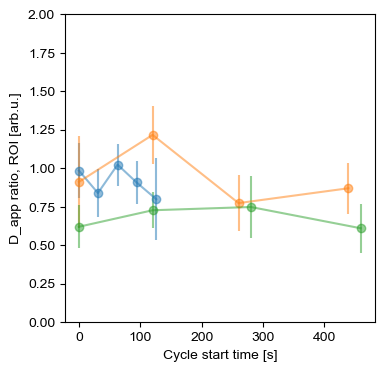

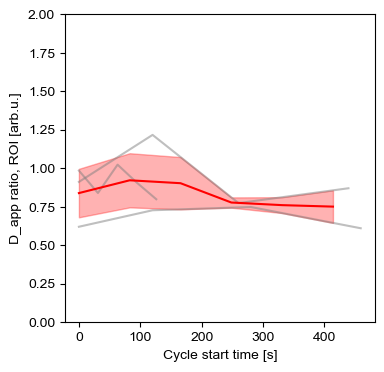

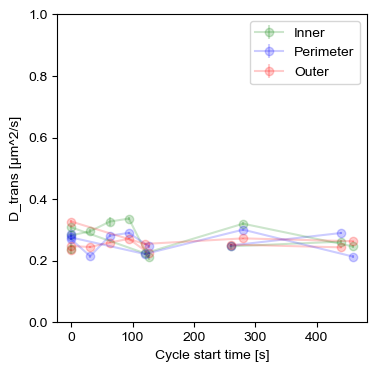

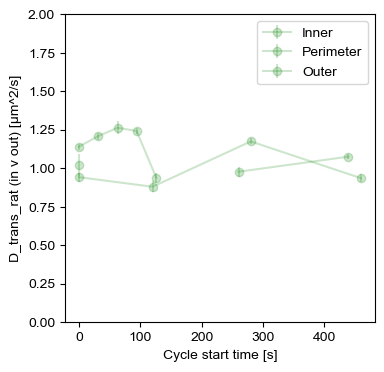

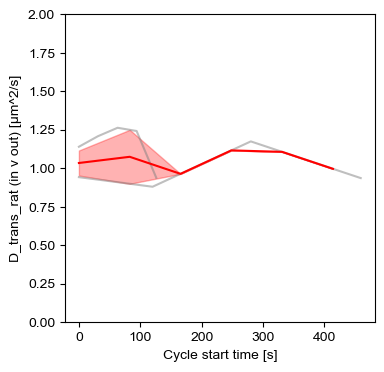

In [3]:
# plot diffusion analysis vs time for all events

cycletime_cycles_all = []
dapps_in_cycles_all = []
dapps_out_cycles_all = []
dapps_ratio_cycles_all = []
dapps_in_sem_cycles_all = []
dapps_out_sem_cycles_all = []
dapps_ratio_sem_cycles_all = []
dser_combos_all = []
for dser_combo in dser_combos:
    cycletime_dser = []
    dapps_in_dser = []
    dapps_out_dser = []
    dapps_ratio_dser = []
    dapps_in_sem_dser = []
    dapps_out_sem_dser = []
    dapps_ratio_sem_dser = []
    for row in dapps_all:
        if row[0][:-2] == dser_combo:
            cycletime_dser.append(row[0][-1])
            dapps_in_dser.append(row[1])
            dapps_out_dser.append(row[2])
            dapps_ratio_dser.append(row[3])
            dapps_in_sem_dser.append(row[4])
            dapps_out_sem_dser.append(row[5])
            dapps_ratio_sem_dser.append(row[6])
    cycletime_cycles_all.append(cycletime_dser)
    dapps_in_cycles_all.append(dapps_in_dser)
    dapps_out_cycles_all.append(dapps_out_dser)
    dapps_ratio_cycles_all.append(dapps_ratio_dser)
    dapps_in_sem_cycles_all.append(dapps_in_sem_dser)
    dapps_out_sem_cycles_all.append(dapps_out_sem_dser)
    dapps_ratio_sem_cycles_all.append(dapps_ratio_sem_dser)
    dser_combos_all.append(dser_combo)

fig = plt.figure(figsize=(4,4))
plot_idx_cum = 0
for dser, cycletimes, dappratio, dappratio_sem in zip(dser_combos_all, cycletime_cycles_all, dapps_ratio_cycles_all, dapps_ratio_sem_cycles_all):
    # Plot vs cycle start time
    try:
        plt.errorbar(cycletimes, dappratio, dappratio_sem, fmt='o-', alpha=0.5)
        plt.xlabel('Cycle start time [s]')
        plt.ylabel('D_app ratio, ROI [arb.u.]')
        plt.ylim(0,2);
    except:
        pass
    plot_idx_cum += 1
plt.show()

fig = plt.figure(figsize=(4,4))
smooth_rolling_window = 1
t_lim_max = 0
t_lim_min = 0
y_lim_max_spot = 0
y_lim_max_large = 0
dappratios_sm_all = []
for cycletime, dappratio in zip(cycletime_cycles_all, dapps_ratio_cycles_all):
    dappratios_sm = uniform_filter1d(dappratio, size=smooth_rolling_window, mode='nearest')
    plt.plot(cycletime, dappratios_sm, '-', color='gray', alpha=0.5)
    dappratios_sm_all.append(dappratios_sm)
X_fit = np.linspace(0, 2400, 30)
y_all = [ls for ls in dappratios_sm_all]
yintp_all_dappratios = []
for t, y in zip(cycletime_cycles_all, y_all):
    yintp = np.interp(X_fit, t, y)
    yintp[(X_fit<np.min(t))] = np.nan
    yintp[(X_fit>np.max(t))] = np.nan
    yintp_all_dappratios.append(yintp)
plt.plot(X_fit, np.nanmean(yintp_all_dappratios, axis=0), 'r')
plt.fill_between(X_fit, np.nanmean(yintp_all_dappratios, axis=0)-np.nanstd(yintp_all_dappratios, axis=0), np.nanmean(yintp_all_dappratios, axis=0)+np.nanstd(yintp_all_dappratios, axis=0), color='r', alpha=0.3)
plt.ylim([0,2])
plt.xlabel('Cycle start time [s]')
plt.ylabel('D_app ratio, ROI [arb.u.]')

plt.show()

cycletime_cycles_all = []
cycletime_rats_cycles_all = []
dtrans_inner_cycles_all = []
dtrans_peri_cycles_all = []
dtrans_outer_cycles_all = []
dtrans_inner_sem_cycles_all = []
dtrans_peri_sem_cycles_all = []
dtrans_outer_sem_cycles_all = []
dtansrats_cycles_all = []
dtansrats_sem_cycles_all = []
dser_combos_all = []
dtrans_rats_dser_all = []
dtrans_rats_sem_dser_all = []
for dser_combo in dser_combos:
    cycletime_rats_dser = []
    cycletime_dser = []
    dtrans_inner_dser = []
    dtrans_peri_dser = []
    dtrans_outer_dser = []
    dtrans_inner_sem_dser = []
    dtrans_peri_sem_dser = []
    dtrans_outer_sem_dser = []
    dtrans_rats_dser = []
    dtrans_rats_sem_dser = []
    for row1, row2 in zip(dtrans_all, dtrans_rats_all):
        if row1[0][:-2] == dser_combo:
            cycletime_dser.append(row1[0][-1])
            dtrans_inner_dser.append(row1[1])
            dtrans_peri_dser.append(row1[2])
            dtrans_outer_dser.append(row1[3])
            dtrans_inner_sem_dser.append(row1[4])
            dtrans_peri_sem_dser.append(row1[5])
            dtrans_outer_sem_dser.append(row1[6])
        if row2[0][:-2] == dser_combo:
            cycletime_rats_dser.append(row2[0][-1])
            dtrans_rats_dser.append(row2[1])
            dtrans_rats_sem_dser.append(row2[4])
    dser_combos_all.append(dser_combo)
    cycletime_cycles_all.append(cycletime_dser)
    cycletime_rats_cycles_all.append(cycletime_rats_dser)
    dtrans_inner_cycles_all.append(dtrans_inner_dser)
    dtrans_peri_cycles_all.append(dtrans_peri_dser)
    dtrans_outer_cycles_all.append(dtrans_outer_dser)
    dtrans_inner_sem_cycles_all.append(dtrans_inner_sem_dser)
    dtrans_peri_sem_cycles_all.append(dtrans_peri_sem_dser)
    dtrans_outer_sem_cycles_all.append(dtrans_outer_sem_dser)
    dtrans_rats_dser_all.append(dtrans_rats_dser)
    dtrans_rats_sem_dser_all.append(dtrans_rats_sem_dser)

fig = plt.figure(figsize=(4,4))
plot_idx_cum = 0
for dser, cycletimes, dtransinner, dtransinner_sem, dtransperi, dtransperi_sem, dtransouter, dtransouter_sem in zip(dser_combos_all, cycletime_cycles_all, dtrans_inner_cycles_all, dtrans_inner_sem_cycles_all, dtrans_peri_cycles_all, dtrans_peri_sem_cycles_all, dtrans_outer_cycles_all, dtrans_outer_sem_cycles_all):
    # Plot vs cycle start time
    try:
        plt.errorbar(cycletimes, dtransinner, dtransinner_sem, fmt='o-', color='green', alpha=0.2)
        plt.errorbar(cycletimes, dtransperi, dtransperi_sem, fmt='o-', color='blue', alpha=0.2)
        plt.errorbar(cycletimes, dtransouter, dtransouter_sem, fmt='o-', color='red', alpha=0.2)
        plt.xlabel('Cycle start time [s]')
        plt.ylabel('D_trans [µm^2/s]')
        plt.ylim(0,1);
        plot_idx_cum += 1
        plt.legend(['Inner','Perimeter','Outer'])
    except:
        pass
plt.show()

fig = plt.figure(figsize=(4,4))
plot_idx_cum = 0
for dser, cycletimes, dtrans_rats, dtrans_rats_sem in zip(dser_combos_all, cycletime_cycles_all, dtrans_rats_dser_all, dtrans_rats_sem_dser_all):
    # Plot vs cycle start time
    try:
        plt.errorbar(cycletimes, dtrans_rats, dtrans_rats_sem, fmt='o-', color='green', alpha=0.2)
        plt.xlabel('Cycle start time [s]')
        plt.ylabel('D_trans_rat (in v out) [µm^2/s]')
        plt.ylim(0,2);
        plot_idx_cum += 1
        plt.legend(['Inner','Perimeter','Outer'])
    except:
        pass
plt.show()

plt.figure(figsize=(4,4))
smooth_rolling_window = 1
t_lim_max = 0
t_lim_min = 0
y_lim_max_spot = 0
y_lim_max_large = 0
dtransrats_sm_all = []
for cycletime, dtransrat in zip(cycletime_cycles_all, dtrans_rats_dser_all):
    dtransrats_sm = uniform_filter1d(dtransrat, size=smooth_rolling_window, mode='nearest')
    plt.plot(cycletime, dtransrats_sm, '-', color='gray', alpha=0.5)
    dtransrats_sm_all.append(dtransrats_sm)
X_fit = np.linspace(0, 2400, 30)
y_all = [ls for ls in dtransrats_sm_all]
yintp_all_dappratios = []
for t, y in zip(cycletime_cycles_all, y_all):
    yintp = np.interp(X_fit, t, y)
    yintp[(X_fit<np.min(t))] = np.nan
    yintp[(X_fit>np.max(t))] = np.nan
    yintp_all_dappratios.append(yintp)
    #plt.plot(X_fit, yintp, alpha=0.3)
plt.plot(X_fit, np.nanmean(yintp_all_dappratios, axis=0), 'r')
plt.fill_between(X_fit, np.nanmean(yintp_all_dappratios, axis=0)-np.nanstd(yintp_all_dappratios, axis=0), np.nanmean(yintp_all_dappratios, axis=0)+np.nanstd(yintp_all_dappratios, axis=0), color='r', alpha=0.3)
plt.ylim([0,2])
plt.xlabel('Cycle start time [s]')
plt.ylabel('D_trans_rat (in v out) [µm^2/s]')
plt.show()

c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\gag\241114
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\gag\250117


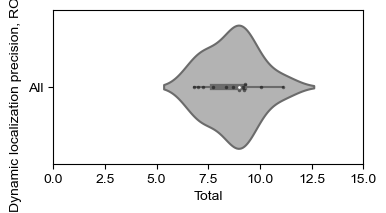

All comb: 8.674 +- 0.329 nm


In [4]:
# PLOT 3D LOCALIZATION PRECISION FROM ALL
locprecs_all = []
dser_combos = []

for folder in folders:
    print(folder)
    analysis = DiffusionAnalysis3D('analysis')
    analysis.load_pickleddata(folder)
    analysis.roi_data['date'] = pd.DataFrame([folder.split('\\')[-1] for i in range(len(analysis.roi_data))])
    analysis.track_data['date'] = pd.DataFrame([folder.split('\\')[-1] for i in range(len(analysis.track_data))])
    dates = analysis.track_data['date'].unique()
    for date in dates:
        data_d = analysis.track_data[analysis.track_data['date']==date].copy()
        samples = data_d['sample'].unique()
        for sample in samples:
            data_ds = data_d[data_d['sample']==sample].copy()
            events = data_ds['event'].unique()
            for event in events:
                data_dse = data_ds[data_ds['event']==event].copy()
                roinames = data_dse['roiname'].unique()
                for roiname in roinames:
                    data_dser = data_dse[data_dse['roiname']==roiname].copy()
                    cycles = data_dser['cycle'].unique()
                    dser_combos.append([date, sample, event, roiname])
                    for cycle in cycles:
                        data_dserc = data_dser[data_dser['cycle']==cycle].copy()
                        locprecs = []
                        for _, row in data_dserc.iterrows():
                            if row['inout_flag'] == True:
                                if len(row['dists_in']) > 0 or len(row['dists_out']):
                                    dists = np.concatenate([row['dists_in'],row['dists_out']])
                                    dts = np.concatenate([row['dts_in'],row['dts_out']])
                                    if len(dists) > fit_len_thresh:
                                        x_fit = np.array([x for _, x in sorted(zip(dts, dists))])
                                        t_fit = np.array([t for t, _ in sorted(zip(dts, dists))])
                                        popt_msd, _ = curve_fit(f_msd, t_fit, x_fit)
                                        locprecs.append(popt_msd[1])
                        if len(locprecs) > n_tracks_lim_dapp and np.mean(locprecs)>0:
                            locprecs_all.append(np.array([np.mean(locprecs)]))
                            
locprec_all = np.concatenate([locprecs_all])
locprecs = [locprec*1000 for locprec in locprec_all]
locprecs = np.array([locprec for locprec in locprecs if locprec==locprec])
locprecs = np.concatenate(locprecs)
dataall = {'Type 1': ['All'] * len(locprecs),
         'Total': np.array(locprecs)}
df_all = pd.concat([pd.DataFrame(d) for d in [dataall]], ignore_index=True)

# plot
fig = plt.figure(figsize=(4, 2))
my_palette = {'All': (0.7,0.7,0.7)}
sns.swarmplot(y='Type 1', x='Total', data=df_all, color='#000000', size=2.5, alpha=0.5)
sns.violinplot(y='Type 1', x='Total', data=df_all, inner='box', palette=my_palette)
plt.ylabel('Dynamic localization precision, ROI [nm]')
plt.xlim(0,15)
plt.show()

print(f'All comb: {np.mean(locprecs):.3f} +- {np.std(locprecs)/np.sqrt(len(locprecs)):.3f} nm')

In [5]:
### DAPP AND DTRANS ALL PLOTTING
dates_dtrans = [int(arr[0][0]) for arr in dtrans_all if ~np.isnan(arr[1])]
dtrans_in = [arr[1] for arr in dtrans_all if ~np.isnan(arr[1])]
dtrans_out = [arr[3] for arr in dtrans_all if ~np.isnan(arr[1])]
dtrans = np.concatenate([dtrans_in, dtrans_out])
df_dtrans = pd.DataFrame({'Date': np.concatenate([dates_dtrans, dates_dtrans]), 'dtrans': dtrans, 'InOut': np.concatenate([np.zeros(len(dtrans_in)), np.ones(len(dtrans_out))])})

dates_dapp = [int(arr[0][0]) for arr in dapps_all if ~np.isnan(arr[1])]
dapp_in = [arr[1] for arr in dapps_all if ~np.isnan(arr[1])]
dapp_out = [arr[2] for arr in dapps_all if ~np.isnan(arr[1])]
dapp = np.concatenate([dapp_in, dapp_out])
df_dapp = pd.DataFrame({'Date': np.concatenate([dates_dapp, dates_dapp]), 'dapp': dapp, 'InOut': np.concatenate([np.zeros(len(dapp_in)), np.ones(len(dapp_out))])})

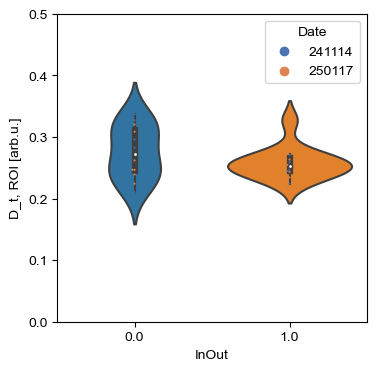

Dtrans in: 0.275 +- 0.012 µm^2/s
Dtrans out: 0.258 +- 0.007 µm^2/s


In [6]:
# PLOT DTRANS - experiments color-coded
fig = plt.figure(figsize=(4, 4))
my_palette = {'In': (0.6,0.6,0.6), 'Out': (0.9,0.9,0.9)}
sns.swarmplot(y='dtrans', x='InOut', hue='Date', data=df_dtrans, size=1.5, alpha=1.0, palette="deep")
sns.violinplot(y='dtrans', x='InOut', data=df_dtrans, inner='box')#, palette=my_palette)
plt.ylabel('D_t, ROI [arb.u.]')
plt.ylim(0,0.5)
plt.show()

print(f'Dtrans in: {np.mean(dtrans_in):.3f} +- {np.std(dtrans_in)/np.sqrt(len(dtrans_in)):.3f} µm^2/s')
print(f'Dtrans out: {np.mean(dtrans_out):.3f} +- {np.std(dtrans_out)/np.sqrt(len(dtrans_out)):.3f} µm^2/s')

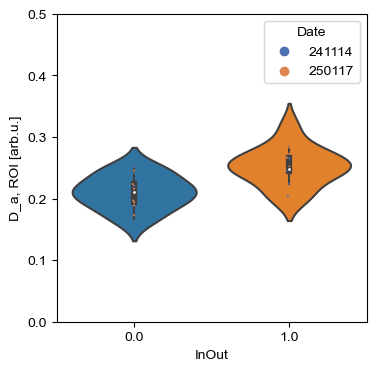

Dapp in: 0.210 +- 0.007 µm^2/s
Dapp out: 0.252 +- 0.008 µm^2/s


In [7]:
# PLOT DAPP - experiments color-coded
fig = plt.figure(figsize=(4, 4))
my_palette = {'In': (0.6,0.6,0.6), 'Out': (0.9,0.9,0.9)}
sns.swarmplot(y='dapp', x='InOut', hue='Date', data=df_dapp, size=1.5, alpha=1.0, palette="deep")
sns.violinplot(y='dapp', x='InOut', data=df_dapp, inner='box')#, palette=my_palette)
plt.ylabel('D_a, ROI [arb.u.]')
plt.ylim(0,0.5)
plt.show()

print(f'Dapp in: {np.mean(dapp_in):.3f} +- {np.std(dapp_in)/np.sqrt(len(dapp_in)):.3f} µm^2/s')
print(f'Dapp out: {np.mean(dapp_out):.3f} +- {np.std(dapp_out)/np.sqrt(len(dapp_out)):.3f} µm^2/s')